In [ ]:
# Load the TensorBoard notebook extension
# !pip install tensorflow==1.15.0
# !pip install keras==2.2.4 
%load_ext tensorboard
%tensorflow_version 2.x
# %keras_version 1.x


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
import cv2
import os
from PIL import Image
import io
from io import BytesIO
from skimage import feature
import numpy as np
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
import numpy as np
import pandas as pd
from keras.datasets import mnist

from tensorflow.keras.utils import to_categorical
import keras
import cv2

from keras.datasets import mnist, cifar10, cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Lambda, concatenate, add
from keras.models import Model
# from custom_layer import Exp_max
import tensorflow as tf
import numpy as np
from skimage.feature import greycomatrix
from tensorflow.keras.utils import plot_model

In [ ]:


def load_data(image_path):
  image_data = []
  image_label = []
  for (root, dirs, file) in os.walk(image_path):
      for f in file:
        l = root.split('/')
        image_label.append(l[-1])
        # image = f.read()
        image = Image.open(root+'/'+f)
        image = image.resize([128, 128], Image.ANTIALIAS)
        image = np.array(image)
        image_data.append(image)
        # print(l[-1],f)
  mapping = {}
  total_image_label = list(set(image_label))
  for x in range(len(total_image_label )):
    mapping[total_image_label[x]] = x

  # integer representation
  for x in range(len(image_label)):
    image_label[x] = mapping[image_label[x]]
  
  return np.array(image_data), np.array(image_label)

In [ ]:
train_path = "drive/MyDrive/Datasets/KTH/train"
valid_path = "drive/MyDrive/Datasets/KTH/valid"

train_image,train_label = load_data(train_path)
valid_image,valid_label = load_data(valid_path)

In [ ]:
tr_i,tr_l,va_i,va_l = np.save("train_image",train_image,),np.save("train_label",train_label,),np.save("valid_image",valid_image,),np.save("valid_label",valid_label,)

In [ ]:
train_image_path = "drive/MyDrive/Datasets/KTH/csv_data/train_image.npy"
train_label_path = "drive/MyDrive/Datasets/KTH/csv_data/train_label.npy"
valid_image_path = "drive/MyDrive/Datasets/KTH/csv_data/valid_image.npy"
valid_label_path = "drive/MyDrive/Datasets/KTH/csv_data/valid_label.npy"

train_image, train_label = np.load(train_image_path), np.load(train_label_path)
valid_image, valid_label = np.load(valid_image_path), np.load(valid_label_path)

In [ ]:
import csv

def readcsv(file):
  datafile = open(FileExistsError, 'r')
  datareader = csv.reader(datafile, delimiter=';')
  data = []
  for row in datareader:
      data.append(row)    
  print (data[1:4])

In [ ]:
# train_image = np.array(train_image)
valid_image.shape

(1600, 331, 331, 3)

In [ ]:

class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

In [ ]:
desc = LocalBinaryPatterns(24, 8)
data = []

In [ ]:
for image in train_image:
	# load the image, convert it to grayscale, and describe it
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	hist = desc.describe(gray)
	# extract the label from the image path, then update the
	# label and data lists
	data.append(hist)

In [ ]:
data = np.array(data)

In [ ]:
data.sha

(1595, 26)

In [ ]:
def create_lbp_model(input_shape):
  image_input = Input(shape=input_shape)
  #image_glcm_input = Input(shape=input_shape)
  # M  = MaxPooling2D((2, 2))
  # 16 filter convolution
  # cov_16 = Conv2D(16, (3, 3), activation='elu')
  cov_16 = Conv2D(1, (3, 3), activation='elu')
  
  x = cov_16(image_input)
  #z = cov_16(image_glcm_input)
  # M  = MaxPooling2D((2, 2))
  x = MaxPooling2D((2, 2))(x)
  #z = MaxPooling2D((2, 2))(z)
  x = BatchNormalization()(x)
  # 32 filter convolution
  cov_32 = Conv2D(32, (3, 3), activation='elu')

  # t = Lambda(find_grad_sum)(x)
  # z = concatenate([z, t])
  # z = add([z,t])
  # x = add([z,x])
  x = cov_32(x)
  # z = cov_32(z)

  x = MaxPooling2D((2, 2))(x)
  # z = MaxPooling2D((2, 2))(z)
  # 64 filter convolution
  cov_64 = Conv2D(64, (3, 3), activation='elu')

  # # t = Lambda(find_grad_sum)(x)
  # # # z = concatenate([z, t])
  # # z = add([z,t])
  # # x = add([z,x])
  x = cov_64(x)
  #z = cov_64(z)

  x = MaxPooling2D((2, 2))(x)
  #z = MaxPooling2D((2, 2))(z)
  #final = concatenate([z,x])
  #final = add([z,x])
  final = Flatten()(x)

  final = Dense(128, activation='elu')(final)
  # final = Dense(128, activation='elu')(final)

  out = Dense(11, activation='softmax')(final)
  model = Model(image_input, out)
  return model

In [ ]:
import os
import tensorflow as tf
import datetime
input_shape = (200,200,3)
# model = create_original_model(input_shape = input_shape)
model = create_lbp_model(input_shape)
# create_grad_model
print(model.summary())

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, \
batch_size=8, write_graph=False, write_grads=True, write_images=True, embeddings_freq=0, \
embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
# train_size = 5000
# test_size = 3000

# train_size = 15000
# test_size = 4000
# train_images = train_images[:train_size]
# train_labels = train_labels[:train_size]
# test_images = test_images[:test_size]
# test_labels = test_labels[:test_size]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 198, 198, 1)       28        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 99, 99, 1)        0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 99, 99, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 97, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0   

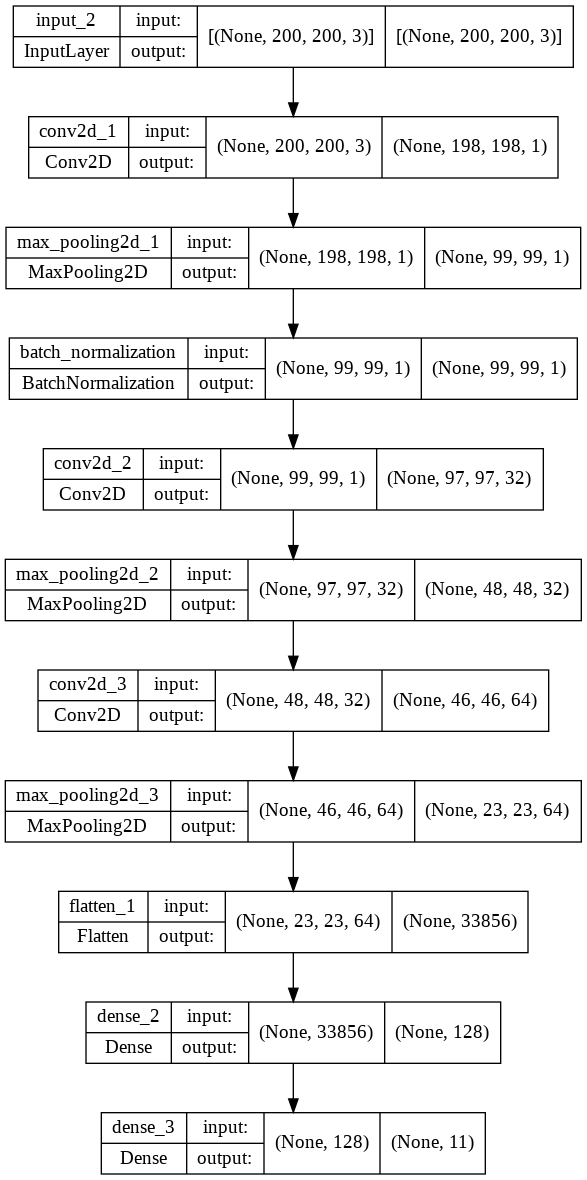

In [ ]:
model.compile(
      # optimizer=tf.keras.optimizers.Adadelta(learning_rate=1e-3, ),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    train_image.astype(np.float32), train_label.astype(np.float32),
    epochs=100,
    # steps_per_epoch=60,
    validation_data=(valid_image, valid_label),
   # validation_steps = 60,
    verbose=1,
    callbacks=[tensorboard_callback]
)

# history = model.fit([train_images.astype('float32'),train_extr_features],train_labels, 
#                     epochs = 100, #steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=([val_images.astype('float32'),val_extr_features], validation_labels),
#                     #validation_steps = STEP_SIZE_VALID,
#                     callbacks=[tensorboard_callback])

Epoch 1/100
50/50 [==============================] - 28s 550ms/step - loss: 301.7354 - sparse_categorical_accuracy: 0.1442 - val_loss: 31.8120 - val_sparse_categorical_accuracy: 0.0981
Epoch 2/100
50/50 [==============================] - 23s 463ms/step - loss: 14.4284 - sparse_categorical_accuracy: 0.2840 - val_loss: 10.9331 - val_sparse_categorical_accuracy: 0.2644
Epoch 3/100
50/50 [==============================] - 23s 465ms/step - loss: 3.9987 - sparse_categorical_accuracy: 0.5185 - val_loss: 8.2771 - val_sparse_categorical_accuracy: 0.2825
Epoch 4/100
50/50 [==============================] - 24s 491ms/step - loss: 1.7819 - sparse_categorical_accuracy: 0.6897 - val_loss: 7.5624 - val_sparse_categorical_accuracy: 0.2831
Epoch 5/100
50/50 [==============================] - 26s 534ms/step - loss: 1.1376 - sparse_categorical_accuracy: 0.7749 - val_loss: 8.0338 - val_sparse_categorical_accuracy: 0.2850
Epoch 6/100
50/50 [==============================] - 27s 536ms/step - loss: 0.6982 - 

In [ ]:
import matplotlib.pyplot as plt
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

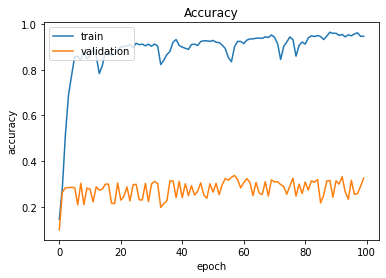

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()